In [1]:
%pylab inline
import seaborn as sns
from scipy import stats
import pandas as pd
import requests
import json
from pandas.io.json import json_normalize

Populating the interactive namespace from numpy and matplotlib


C:\Users\Danny\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
C:\Users\Danny\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(obj):  # Create a dummy variable that just returns whatever it's passed if tqdm doesn't exist
        return(obj)

In [3]:
from keys import trakt_api_key
if trakt_api_key == "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx":
    raise Exception('trakt API key needed. This can be obtained from here: https://trakt.tv/oauth/applications/new')

In [4]:
# Set the headers for the trakt API requests
headers={
  'Content-Type': 'application/json',
  'trakt-api-version': '2',
  'trakt-api-key': trakt_api_key
}

In [5]:
search_string = raw_input("Please type in a show name :")

Please type in a show name :Game of thrones


In [6]:
# Find best match in trakt.tv
request = requests.get("https://api-v2launch.trakt.tv/search?query={}&type=show".format(search_string), headers=headers)
show_search_data = json_normalize(json.loads(request.text))
print("Best match : {}".format(show_search_data['show.title'][0]))
show_id = show_search_data['show.ids.slug'][0]

Best match : Game of Thrones


In [7]:
request = requests.get("https://api-v2launch.trakt.tv/shows/{}".format(show_id), headers=headers)
show_summary = json_normalize(json.loads(request.text))

request = requests.get("https://api-v2launch.trakt.tv/shows/{}/stats".format(show_id), headers=headers)
show_stats = json_normalize(json.loads(request.text))

request = requests.get("https://api-v2launch.trakt.tv/shows/{}/seasons?extended=episodes".format(show_id), headers=headers)
show_seasons_list = json_normalize(json.loads(request.text))

episode_df = pd.concat([json_normalize(ep) for ep in show_seasons_list.episodes])

In [8]:
episodes_summaries = []
episodes_ratings = []
episodes_stats = []

for index, episode in tqdm(episode_df.iterrows(), total=len(episode_df)):

    # Fetch summary (for Synopsis)
    request = requests.get("https://api-v2launch.trakt.tv/shows/{id}/seasons/{season}/episodes/{episode}?extended=full".format(id=show_id,
                                                                                                                               season=episode.season,
                                                                                                                               episode=episode.number), headers=headers)
    episode_summary = json_normalize(json.loads(request.text))
    episodes_summaries.append(episode_summary)
    
    
    # The code below fetches additional information that isn't currently used. It may be useful for future development
    
    # fetch ratings (for histogram breakdown of ratings)

    #request = requests.get("https://api-v2launch.trakt.tv/shows/{id}/seasons/{season}/episodes/{episode}/ratings".format(id=show_id,
    #                                                                                                                     season=episode.season,
    #                                                                                                                     episode=episode.number), headers=headers)
    #episode_ratings = json_normalize(json.loads(request.text))


    # fetch other stats (to get more details stats like "watchers", "plays", "collectors", "collected_episodes", "comments", "lists"
    # "votes", etc.

    #request = requests.get("https://api-v2launch.trakt.tv/shows/{id}/seasons/{season}/episodes/{episode}/stats".format(id=show_id,
    #                                                                                                                   season=episode.season,
    #                                                                                                                   episode=episode.number), headers=headers)
    #episode_stats = json_normalize(json.loads(request.text))





100%|██████████████████████████████████████████| 77/77 [00:24<00:00,  3.30it/s]


In [9]:
full_episode_df = pd.concat(episodes_summaries)
full_episode_df['first_aired'] = pd.to_datetime(full_episode_df.first_aired)

full_episode_df.to_csv(show_summary.title[0] + ".csv", encoding='utf-8')

In [10]:
# Remove specials and episodes that haven't aired, and group episodes by season
main_episodes = full_episode_df[(full_episode_df.season > 0) & (full_episode_df.first_aired < pd.datetime.now())]
main_episodes.number_abs = range(1, len(main_episodes)+1)

groups = main_episodes.groupby("season")
pal = sns.color_palette(n_colors=len(groups))

C:\Users\Danny\Anaconda\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


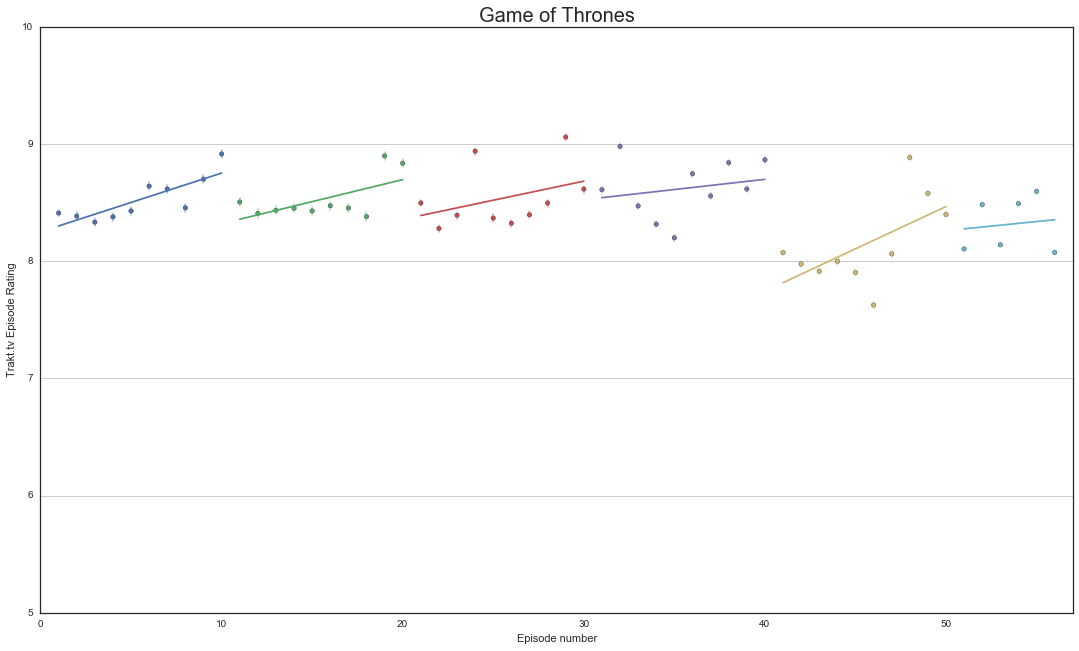

In [11]:
# Generate static image plot
sns.set_style('white')

for name, group in groups:
    
    c = np.array([pal[name-1]]*len(group))
    
    plt.scatter(x=group.number_abs,
                y=group.rating,
                c=np.array([pal[name-1]]*len(group))
                )

    
    polyfit_coef = np.polyfit(group.number_abs, group.rating, 1)
    plt.plot(group.number_abs, np.poly1d(polyfit_coef)(group.number_abs), c=c[0])
    
    for name, episode in group.iterrows(): # add seasons_titles again when it works
        rating = episode.rating
        error = 2.0 / episode.votes ** .5
        #plt.text(running_x + 0.04, rating - error - 0.5, title, rotation='vertical', ha='center', va='top', size='xx-small')
        plt.plot((episode.number_abs, episode.number_abs), (rating - error, rating + error), c=c[0], alpha=0.4)
        
plt.xlim(0,main_episodes.number_abs.max()+1)
plt.ylim(5,10)
plt.grid(True, axis='y')
plt.title(show_summary.title[0], size=20)
plt.ylabel('Trakt.tv Episode Rating')
plt.xlabel('Episode number')

plt.gcf().set_size_inches(18.5, 10.5)
plt.savefig(show_summary.title[0] + ".png", dpi=300)

In [12]:
# interactive mpld3 plot

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mpld3
from mpld3 import plugins
pd.options.display.max_colwidth = 1000
#plt.style.use('seaborn-white')

# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
  width: 300px;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

fig, ax = plt.subplots()
ax.grid(True, axis='y', alpha=0.9)

df = main_episodes

# Plot trendlines
for name, group in groups:
    c = np.array([pal[name-1]]*len(group))
    polyfit_coef = np.polyfit(group.number_abs, group.rating, 1)
    plt.plot(group.number_abs, np.poly1d(polyfit_coef)(group.number_abs), c=c[0], zorder=1)
    
    for name, episode in group.iterrows(): # add seasons_titles again when it works
        rating = episode.rating
        error = 2.0 / episode.votes ** .5
        #plt.text(running_x + 0.04, rating - error - 0.5, title, rotation='vertical', ha='center', va='top', size='xx-small')
        plt.plot((episode.number_abs, episode.number_abs), (rating - error, rating + error), c=c[0], alpha=0.4, zorder=1)

# Generate HTML hover tooltip labels
labels = []
columns_for_labels = ['season', 'number', 'rating', 'votes', 'first_aired', 'overview']
column_rename_map = {'season': 'Season',
                     'number': 'Episode',
                     'rating' : 'Rating',
                     'votes' : 'Votes',
                     'first_aired' : 'Air date', 
                     'overview' : 'Synopsis'}
for i in range(len(df)):
    label = df.iloc[[i]][columns_for_labels].T
    label.columns = df.iloc[[i]].title
    labels.append(label.rename(column_rename_map).to_html())

# Plot scatter points
c = (df.season-1).map(pd.Series(list(sns.color_palette(n_colors=len(df.season.value_counts())))))
points = ax.scatter(df.number_abs, df.rating, alpha=.99, c=c, zorder=2)


ax.set_ylim(5,10)
ax.set_xlim(0,main_episodes.number_abs.max()+1)
ax.set_ylabel('Trakt.tv Episode Rating')
ax.set_xlabel('Episode number')
fig.set_size_inches(12, 6)
ax.set_title(show_summary.title[0], size=20)

tooltip = plugins.PointHTMLTooltip(points, labels,
                                   voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

mpld3.save_html(fig, str(show_summary.title[0] + ".html"))
mpld3.display()